In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

2023-01-14 10:55:11.260368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 10:55:11.360362: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-14 10:55:11.364725: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-14 10:55:11.364741: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
train_path = 'images_data/train/'
valid_path = 'images_data/validation/'
test_path = 'images_data/predict'

In [3]:
names_of_people = ['amey', 'sandesh', 'nathan', 'shoydon', 'vedant', 'manasvi', 'srijita']

In [4]:
# img_height, img_width = 640, 480
# batch_size=32
# train_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset='training', seed=123, image_size=(img_height, img_width), batch_size=(batch_size))

train_batches = ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input, width_shift_range=[-200, 200], height_shift_range=0.5, horizontal_flip=True, rotation_range=45) .flow_from_directory(train_path, target_size=(640, 480), classes=names_of_people, batch_size=10, shuffle=True)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(valid_path, target_size=(640,480), 
  classes=names_of_people, batch_size=10, shuffle=True)

Found 348 images belonging to 7 classes.
Found 83 images belonging to 7 classes.


In [5]:
# val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir, 
#   validation_split=0.2,
#   subset='validation',
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=(batch_size)

# )


In [6]:
names_of_people

['amey', 'sandesh', 'nathan', 'shoydon', 'vedant', 'manasvi', 'srijita']

Training the model

In [7]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(include_top=False,
input_shape=(640,480,3),
pooling='avg', 
classes=len(names_of_people),
weights='imagenet')

for layer in pretrained_model.layers:
  layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(Dense(len(names_of_people), activation='softmax'))

2023-01-14 10:55:12.758794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-14 10:55:12.758823: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-14 10:55:12.758840: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-01-14 10:55:12.759050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrapp  (None, 2048)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 64)               131136    
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 7)                455       
 pper)                                                           
                                                                 
Total params: 23,719,303
Trainable params: 131,591
Non-trainable params: 23,587,712
______________________________________

In [9]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
resnet_model.fit(
  x=train_batches,
  validation_data=valid_batches,
  epochs=5,
  verbose=2,
  shuffle=True
)

Epoch 1/5
35/35 - 129s - loss: 1.0849 - accuracy: 0.6667 - val_loss: 0.1804 - val_accuracy: 1.0000 - 129s/epoch - 4s/step
Epoch 2/5
35/35 - 135s - loss: 0.1665 - accuracy: 0.9799 - val_loss: 0.0295 - val_accuracy: 1.0000 - 135s/epoch - 4s/step
Epoch 3/5
35/35 - 136s - loss: 0.0512 - accuracy: 1.0000 - val_loss: 0.0160 - val_accuracy: 1.0000 - 136s/epoch - 4s/step
Epoch 4/5
35/35 - 137s - loss: 0.0275 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 1.0000 - 137s/epoch - 4s/step
Epoch 5/5
35/35 - 122s - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 1.0000 - 122s/epoch - 3s/step


Testing the model

In [11]:
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
  .flow_from_directory(directory=test_path, target_size=(640, 480),
  classes=names_of_people, batch_size=20, shuffle=False)

Found 68 images belonging to 7 classes.


In [12]:
predictions = resnet_model.predict(x=test_batches, verbose=0)

In [13]:
np.round(predictions)

array([[0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
 

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [15]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Confusion Matrix, without normalization")

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")

In [16]:
test_batches.class_indices

{'amey': 0,
 'sandesh': 1,
 'nathan': 2,
 'shoydon': 3,
 'vedant': 4,
 'manasvi': 5,
 'srijita': 6}

Confusion Matrix, without normalization
[[ 9  1  0  0  0  0  0]
 [ 0 10  0  0  0  0  0]
 [ 0  0 10  0  0  0  0]
 [ 0  1  0  8  0  0  0]
 [ 0  0  0  0  9  0  0]
 [ 0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0 10]]


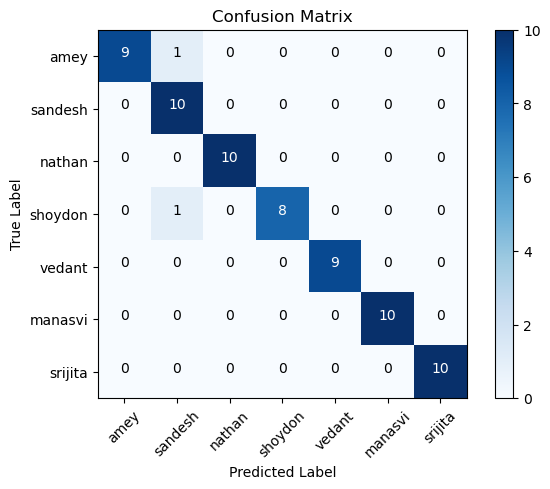

In [17]:
cm_plot_labels = names_of_people
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

In [18]:
resnet_model.evaluate(test_batches)

4/4 [==============================] - 18s 4s/step - loss: 0.2030 - accuracy: 0.9706


[0.2030116468667984, 0.970588207244873]

In [19]:
# resnet_model.save('model/trans_learn_2')